In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np

# sklearn
from imblearn.over_sampling import SMOTE
# modeli
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# ostalo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Sklearn Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# scipy
from scipy import ndimage #za gaussijanski filter
from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy.fft import rfft, rfftfreq

#crtanje
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()
sns.set(style="white")

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class FastFourierTransform(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = np.abs(rfft(X, axis=1))
        return transformed
    
class SavGolTransform(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = savgol_filter(X,101,2,deriv=0)
        transformed = np.array(X) - transformed
        return transformed

class NormalizeTransform(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = normalize(X)
        return transformed

class GaussianFilter(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        transformed = ndimage.filters.gaussian_filter(X, sigma=10)
        return transformed

In [3]:
# Učitaj nanovo podatke bez ikakvih transformacija
def reset_data(df_train, df_test):
    train = df_train.copy()
    test = df_test.copy()
    
    #pretvori LABEL u tvrdnje istinitosti 0 i 1
    train["LABEL"] = train["LABEL"].apply(lambda x: 0 if x==1 else 1)
    test["LABEL"] = test["LABEL"].apply(lambda x: 0 if x==1 else 1)
    
    #razdvoji feature i labele
    X_train = train.drop(["LABEL"], axis = 1)
    y_train = train["LABEL"].ravel()
    X_test = test.drop(["LABEL"], axis = 1)
    y_test = test["LABEL"].ravel()
    
    #makni retke koji sadrže outliere u train data
    zscores = zscore(X_train)
    abszscores = np.abs(zscores)
    filtered_indices = (abszscores<3).all(axis=1)
    X_train = X_train[filtered_indices]
    y_train = y_train[filtered_indices]
    
    return X_train, X_test, y_train, y_test

In [4]:
def draw_exo(data, n):
    if isinstance(data,np.ndarray):        
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            #ax.scatter(np.arange(len(data[0])),data[i][:],s=0.5)
            ax.plot(np.arange(len(data[0])),data[i][:], lw=0.5)
    else:
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            ax.scatter(np.arange(3197),data.iloc[i,:],s=0.5)

def draw_noexo(data, n):
    if isinstance(data,np.ndarray):
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            ax.scatter(np.arange(len(data[0])),data[i+37][:],s=0.5)
    else:
        fig = plt.figure(figsize=(24,40))
        for i in range(n):
            ax = fig.add_subplot(14,4,i+1)
            ax.scatter(np.arange(3197),data.iloc[i+37,:],s=0.5)

In [5]:
data_prep_1 = Pipeline([("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("robust_scaler", RobustScaler()),
                      ("fft", FastFourierTransform())])

data_prep_2 = Pipeline([("fft", FastFourierTransform()),
                      ("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("robust_scaler", RobustScaler()),])

data_prep_3 = Pipeline([("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("robust_scaler", RobustScaler()),])

data_prep_4 = Pipeline([("fft", FastFourierTransform()),
                      ("savgol", SavGolTransform()),
                      ("normalizer", NormalizeTransform()),
                      ("std_scaler", StandardScaler()),])

# data_prep_5 = Pipeline([#("savgol", SavGolTransform()),
#                         ("fft", FastFourierTransform()),
#                         ("savgol", SavGolTransform()),
#                         ("normalizer", NormalizeTransform()),
#                         #("std_scaler", StandardScaler()),
#                         #("savgol", SavGolTransform())
#                         ])

data_prep_5 = Pipeline([("savgol", SavGolTransform()),
                        ("normalizer", NormalizeTransform()),
                        ("fft", FastFourierTransform()),
                        #("savgol", SavGolTransform()),
                        
                        ("std_scaler", StandardScaler()),
                        #("savgol", SavGolTransform())
                        ])

In [6]:
#funkcija za testiranje modela
def test_model(estimator, X_train_, X_test_, y_train_, y_test_):
    estimator.fit(X_train_, y_train_)
    prediction=estimator.predict(X_test_)
    print()
    print(type(estimator).__name__)
    print()
    #ispis svih vrijednosti
    print(classification_report(y_test,prediction))
    #crtanje
    fig = plt.figure(figsize=(22,7), num=type(estimator).__name__)
    ax = fig.add_subplot(1,3,1)
    sns.heatmap(confusion_matrix(y_test_,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    ax = fig.add_subplot(1,3,2)
    metrics.plot_roc_curve(estimator, X_test_, y_test_, ax=ax)
    plt.plot([0, 1], [0, 1], 'k--')
    ax = fig.add_subplot(1,3,3)
    metrics.plot_precision_recall_curve(estimator, X_test_, y_test_, ax=ax)
    f1=metrics.f1_score(y_test_, prediction)
    print("F1:", f1)

In [7]:
print("Loading data...")
train_data = pd.read_csv("exoTrain.csv")#.fillna(0)
test_data = pd.read_csv("exoTest.csv")#.fillna(0)
print("Data loaded.")

Loading data...
Data loaded.


In [44]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_5.fit_transform(X_train)
X_test = data_prep_5.fit_transform(X_test)

# sm = SMOTE(random_state=42, n_jobs=-1)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

Wall time: 3.49 s


In [92]:
# tree = DecisionTreeClassifier(random_state=42)
# tree.fit(X_train, y_train)
# y_pred = tree.predict(X_test)
# confusion_matrix(y_test, y_pred)

In [93]:
# svm = SVC()
# svm.fit(X_train, y_train)
# y_pred = svm.predict(X_test)
# confusion_matrix(y_test, y_pred)

In [52]:
parameters = {
    "criterion": ["entropy"],
    "max_depth": list(range(2,13)),
    #"max_leaf_nodes": list(range(15,36))
    
    #"max_leaf_nodes":
}
 #   "random_state": [42],
# logreg = LogisticRegression(max_iter=500, n_jobs=-1, random_state=42, verbose=1, class_weight="balanced")

#logreg = LogisticRegression()
tree = DecisionTreeClassifier()

grid = GridSearchCV(tree, parameters, cv=5, verbose=1, n_jobs=-1, return_train_score=True, scoring = ["recall","precision","f1"], refit="recall")

In [53]:
grid.fit(X_train, y_train)
grid.best_estimator_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  4.8min finished


DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [54]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [14]:
grid.score(X_test,y_test)
grid.best_estimator_.score(X_test, y_test)
y_pred = grid.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[561,   4],
       [  3,   2]], dtype=int64)

# Ovaj tu štima

In [19]:
#funkcija za testiranje modela
def test_model(estimator, X_train_, X_test_, y_train_, y_test_):
    estimator.fit(X_train_, y_train_)
    prediction=estimator.predict(X_test_)
    print()
    print(type(estimator).__name__)
    print()
    #ispis svih vrijednosti
    print(classification_report(y_test,prediction))
    #crtanje
    fig = plt.figure(figsize=(16,4), num=type(estimator).__name__)
    ax = fig.add_subplot(1,3,1)
    sns.heatmap(confusion_matrix(y_test_,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    ax = fig.add_subplot(1,3,2)
    metrics.plot_roc_curve(estimator, X_test_, y_test_, ax=ax)
    plt.plot([0, 1], [0, 1], 'k--')
    ax = fig.add_subplot(1,3,3)
    metrics.plot_precision_recall_curve(estimator, X_test_, y_test_, ax=ax)
    f1=metrics.f1_score(y_test_, prediction)
    print("F1:", f1)

In [8]:
%%time
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)
X_train = data_prep_5.fit_transform(X_train)
X_test = data_prep_5.fit_transform(X_test)

# sm = SMOTE(random_state=42, n_jobs=-1)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

Wall time: 3.41 s



DecisionTreeClassifier

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       565
           1       0.27      0.60      0.37         5

    accuracy                           0.98       570
   macro avg       0.63      0.79      0.68       570
weighted avg       0.99      0.98      0.99       570

F1: 0.37499999999999994


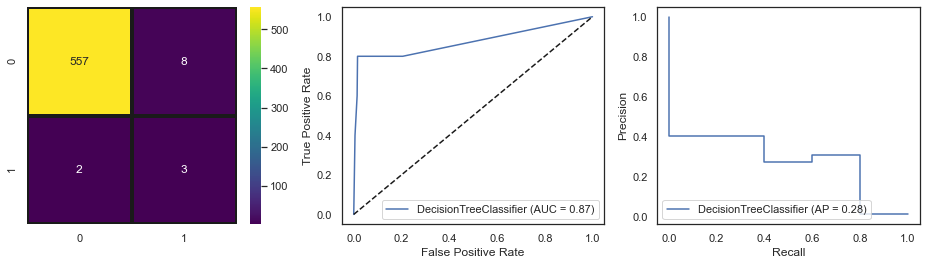

In [43]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=8, max_leaf_nodes=22)
# tree.fit(X_train, y_train)
# tree.score(X_test, y_test)
# y_pred = tree.predict(X_test)
# confusion_matrix(y_test, y_pred)
test_model(tree, X_train, X_test, y_train, y_test)

In [ ]:

DecisionTreeClassifier

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       565
           1       0.33      0.60      0.43         5

    accuracy                           0.99       570
   macro avg       0.66      0.79      0.71       570
weighted avg       0.99      0.99      0.99       570

In [103]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=7, max_leaf_nodes=22)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
confusion_matrix(y_test, y_pred)
#np.argwhere(y_pred)

array([[556,   9],
       [  3,   2]], dtype=int64)

# [560,   5]
# [  2,   3]]

# [557,   8]
# [  2,   3]

In [78]:
X_train, X_test, y_train, y_test = reset_data(train_data, test_data)

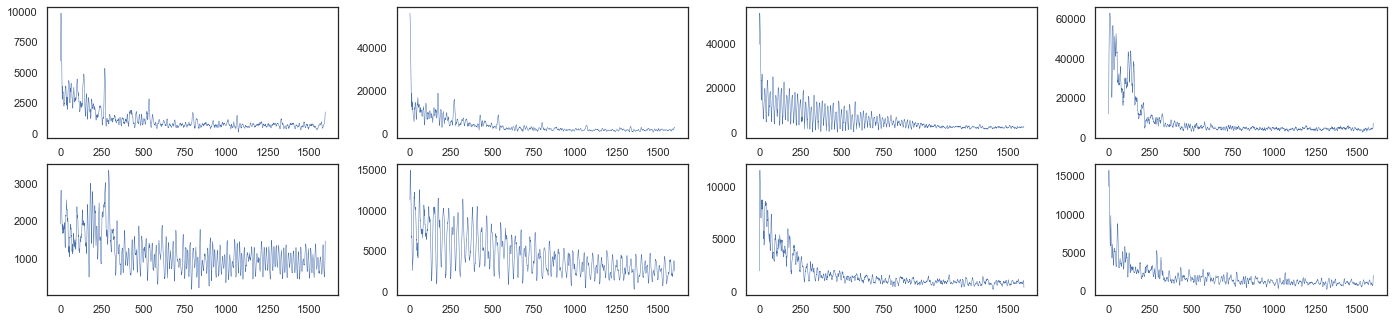

In [82]:
X_test = np.array(X_test)
draw_exo(X_test[y_pred==1],8)

In [98]:
np.argwhere(y_pred).flatten()

array([  0,   2,   4,  21,  39, 124, 258, 470, 513, 514, 545], dtype=int64)

In [80]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_leaf_nodes=2)

In [65]:
# newtree = DecisionTreeClassifier(criterion="entropy", max_depth=3000, max_features=1500)
# newtree.fit(X_train, y_train)
# y_pred = newtree.predict(X_test)
# confusion_matrix(y_test, y_pred)

In [8]:
import joblib
#joblib.dump(grid, "tree-listovi-depth8-final.pkl")
#loaded_grid = joblib.load("tree-17520211552.pkl") #logreg-17520211552.pkl

In [ ]:
# y_pred = loaded_grid.best_estimator_.predict(X_test)
# confusion_matrix(y_test, y_pred)

In [57]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [56]:
results = pd.DataFrame(grid.cv_results_)
#results[["param_C", "param_class_weight", "rank_test_precision"]]
#results.columns
#results["mean_test_recall"], results["mean_test_precision"]

Text(0.5, 1.0, '')

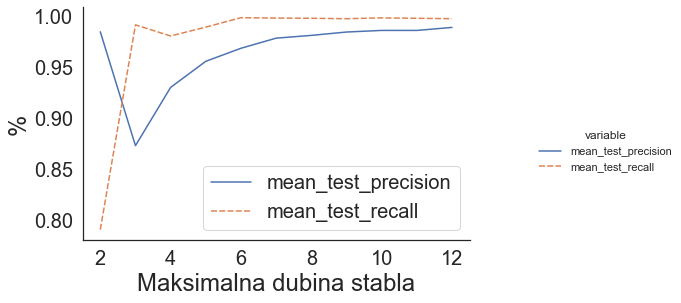

In [57]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

removed = list(results.columns)
removed.remove("mean_test_precision")
removed.remove("mean_test_recall")
res = results.melt(id_vars=removed, value_vars=["mean_test_precision", "mean_test_recall"])



p1 = sns.relplot(
    data=res, kind="line",
    x="param_max_depth", y="value", hue="variable", style="variable",col="param_criterion"#, col="param_criterion", #col="param_criterion",
    #facet_kws=dict(sharey=True),
)
p1.fig.set_size_inches(10,4)
p1.set(xticks=list(range(2,13,2)))
#p1.set(ylabel="%", xlabel="Maksimalna dubina stabla")
plt.xlabel("Maksimalna dubina stabla", fontsize=24)
plt.ylabel("%", fontsize=24)
plt.legend(fontsize=20)
plt.title(label="")

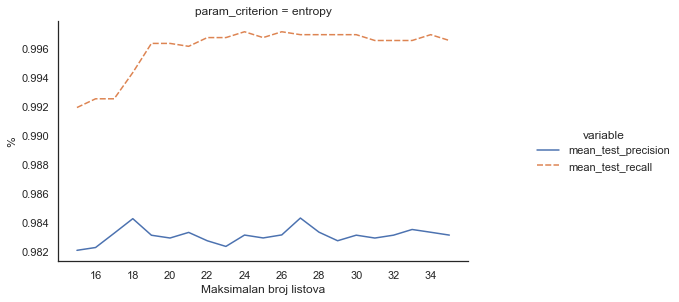

In [89]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

removed = list(results.columns)
removed.remove("mean_test_precision")
removed.remove("mean_test_recall")
res = results.melt(id_vars=removed, value_vars=["mean_test_precision", "mean_test_recall"])

p1 = sns.relplot(
    data=res, kind="line",
    x="param_max_leaf_nodes", y="value", hue="variable", style="variable",col="param_criterion"#, col="param_criterion", #col="param_criterion",
    #facet_kws=dict(sharey=True),
)
p1.fig.set_size_inches(10,4)
p1.set(xticks=list(range(16,36,2)))
#p1.set(ylabel="%", xlabel="Maksimalan broj listova")

plt.xlabel("Maksimalan broj listova", fontsize=24)
plt.ylabel("%", fontsize=24)

In [ ]:
# class_none = results[results["param_class_weight"]!="Balanced"]
# class_balanced = results[results["param_class_weight"]=="Balanced"]

In [132]:
l1 = joblib.load("tree-250520211537.pkl")
l2 = joblib.load("tree-250520211547.pkl")
l1 = pd.DataFrame(l1.cv_results_)
l2 = pd.DataFrame(l2.cv_results_)
results = pd.concat([l1,l2]).reset_index().drop(["index"], axis=1)

#results = pd.DataFrame(loaded_grid.cv_results_)
# gini = results[results["param_criterion"]=="gini"]
# entropy = results[results["param_criterion"]=="entropy"]

Text(0.5, 1.0, '')

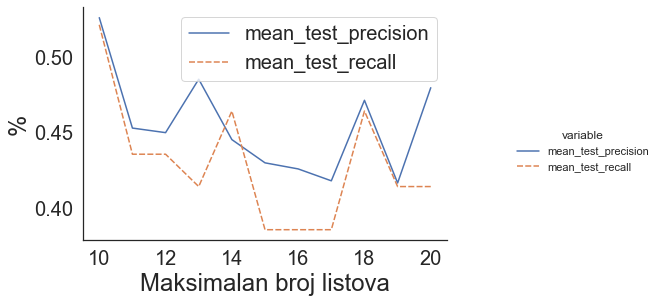

In [42]:
results = joblib.load("tree-030620211820.pkl")
results = pd.DataFrame(results.cv_results_)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

removed = list(results.columns)
removed.remove("mean_test_precision")
removed.remove("mean_test_recall")
res = results.melt(id_vars=removed, value_vars=["mean_test_precision", "mean_test_recall"])



p1 = sns.relplot(
    data=res, kind="line",
    x="param_max_depth", y="value", hue="variable", style="variable", col="param_criterion", #col="param_criterion",
    #facet_kws=dict(sharey=True),
)
p1.fig.set_size_inches(10,4)
#p1.set(xticks=list(range(2,22,2)))
#p1.set(ylabel="%", xlabel="Dubina stabla")

plt.xlabel("Maksimalan broj listova", fontsize=24)
plt.ylabel("%", fontsize=24)
plt.legend(fontsize=20)
plt.title(label="")
# p2 = sns.relplot(
#     data=res, kind="line",
#     x="param_max_depth", y="value", hue="param_criterion", style="variable", col="param_criterion" #col="param_criterion",
#     #facet_kws=dict(sharex=True),
# )
# p2.fig.set_size_inches(10,6)

# p2 = sns.relplot(
#     data=results, kind="line",
#     x="param_max_depth", y="mean_test_recall", hue="param_criterion" #col="param_criterion",
#     #hue="choice", size="coherence", style="choice",
#     #facet_kws=dict(sharex=True),
# )
# p2.fig.set_size_inches(10,6)

In [257]:
# #gini
# gini.plot(x="param_max_depth", y=["mean_test_precision", "mean_test_recall"], figsize=(10,6))
# plt.xlabel("Dubina stabla", fontsize=20)
# plt.ylabel("Preciznost", fontsize=20)
# plt.xticks(list(range(2,21,2)))
# plt.xlim(0,13)
# #plt.legend().set_visible(False)
# #entropy
# entropy.plot(x="param_max_depth", y=["mean_test_precision", "mean_test_recall"], figsize=(10,6))
# plt.xlabel("Dubina stabla", fontsize=20)
# plt.ylabel("Preciznost", fontsize=20)
# plt.xticks(list(range(2,21,2)))
# plt.xlim(0,13)
# #plt.legend().set_visible(False)

In [ ]:
# scores = np.array(gini.mean_test_recall).reshape(5,5) #gini["mean_test_precision"].ravel().reshape((4,4))
# sns.heatmap(scores, xticklabels=gini["param_max_features"].unique(), yticklabels=gini["param_max_depth"].unique(), annot=True, cmap="viridis", linecolor="k", linewidths=1)
# plt.xlabel("max features", fontsize=20)
# plt.ylabel("max depth", fontsize=20)

In [ ]:
# scores = np.array(entropy.mean_test_precision).reshape(4,4) #gini["mean_test_precision"].ravel().reshape((4,4))
# sns.heatmap(scores, xticklabels=entropy["param_max_features"].unique(), yticklabels=entropy["param_max_depth"].unique(), annot=True, cmap="viridis", linecolor="k", linewidths=1)
# plt.xlabel("max features", fontsize=20)
# plt.ylabel("max depth", fontsize=20)

In [69]:
from sklearn.ensemble import BaggingClassifier

In [74]:
%%time
tree = DecisionTreeClassifier(criterion='entropy', max_depth=6)
bag = BaggingClassifier(tree, n_estimators=10, max_samples=1.0, random_state=42, n_jobs=-1)

bag.fit(X_train, y_train)

Wall time: 1min 17s


BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=6),
                  n_estimators=20, n_jobs=-1, random_state=42)

In [75]:
y_pred = bag.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[556,   9],
       [  2,   3]], dtype=int64)

In [86]:
parameters = {
    "base_estimator__criterion": ["gini", "entropy"],
    "base_estimator__max_depth": list(range(4,8)),
    #"max_leaf_nodes":
}
 #   "random_state": [42],
# logreg = LogisticRegression(max_iter=500, n_jobs=-1, random_state=42, verbose=1, class_weight="balanced")

#logreg = LogisticRegression()
tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=10, max_samples=0.8, max_features=0.6, random_state=42, n_jobs=-1)

grid = GridSearchCV(bag, parameters, cv=5, verbose=1, n_jobs=-1, return_train_score=True, scoring = ["recall","precision","f1"], refit="recall")

In [87]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  9.3min finished


GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                         max_features=0.6, max_samples=0.8,
                                         n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__max_depth': [4, 5, 6, 7]},
             refit='recall', return_train_score=True,
             scoring=['recall', 'precision', 'f1'], verbose=1)

In [88]:
y_pred = grid.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[561,   4],
       [  2,   3]], dtype=int64)

In [92]:
results = pd.DataFrame(grid.cv_results_)
#results[["param_C", "param_class_weight", "rank_test_precision"]]
#results.columns
#results["mean_test_recall"]
results["mean_test_precision"]

0    0.989223
1    0.993012
2    0.994803
3    0.995795
4    0.987480
5    0.994407
6    0.996795
7    0.997795
Name: mean_test_precision, dtype: float64

In [251]:
l1 = joblib.load("treebag-250520211655.pkl")
l2 = joblib.load("treebag-250520211820.pkl")
l1 = pd.DataFrame(l1.cv_results_)
l2 = pd.DataFrame(l2.cv_results_)

In [253]:
tree_res = pd.concat([l1,l2]).reset_index().drop(["index"], axis=1)
# gini = tree_res[tree_res["param_base_estimator__criterion"]=="gini"]
# entropy = tree_res[tree_res["param_base_estimator__criterion"]=="entropy"]

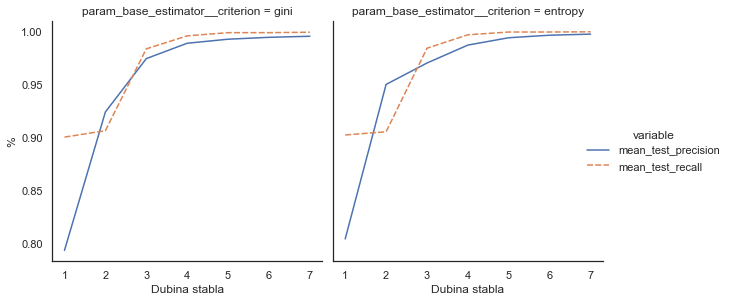

In [259]:
removed = list(tree_res.columns)
removed.remove("mean_test_precision")
removed.remove("mean_test_recall")
res = tree_res.melt(id_vars=removed, value_vars=["mean_test_precision", "mean_test_recall"])



p1 = sns.relplot(
    data=res, kind="line",
    x="param_base_estimator__max_depth", y="value", hue="variable", style="variable", col="param_base_estimator__criterion", #col="param_criterion",
    #facet_kws=dict(sharey=True),
)
p1.fig.set_size_inches(10,4)
p1.set(xticks=list(range(1,8)))
p1.set(ylabel="%", xlabel="Dubina stabla")

In [246]:
# gini.plot(x="param_base_estimator__max_depth", y=["mean_test_precision", "mean_test_recall"], figsize=(10,6))
# plt.xlabel("adsf")
# entropy.plot(x="param_base_estimator__max_depth", y=["mean_test_precision", "mean_test_recall"], figsize=(10,6))

In [263]:
%%time
bag = BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=10, max_samples=0.8, max_features=0.6, random_state=42, n_jobs=-1)
bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)
confusion_matrix(y_test, y_pred)

Wall time: 12.6 s


array([[552,  13],
       [  1,   4]], dtype=int64)

In [268]:
cross_val_score(bag, X_train, y_train)

array([0.99396985, 0.99497487, 0.99798995, 0.99698341, 0.99648064])

In [278]:
%%time
forest = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42, n_jobs=-1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
confusion_matrix(y_test, y_pred)

Wall time: 4.71 s


array([[547,  18],
       [  1,   4]], dtype=int64)

In [271]:
cross_val_score(forest, X_train, y_train)

array([0.9919598 , 0.99296482, 0.99648241, 0.99698341, 0.99798894])

In [272]:
l = [0.9919598 , 0.99296482, 0.99648241, 0.99698341, 0.99798894]
sum(l)/len(l)

0.995275876

In [279]:
parameters = {
    "max_depth": list(range(1,21))
    #"max_leaf_nodes":
}
 #   "random_state": [42],
# logreg = LogisticRegression(max_iter=500, n_jobs=-1, random_state=42, verbose=1, class_weight="balanced")

#logreg = LogisticRegression()
forest = RandomForestClassifier(n_estimators=100, random_state=42)
grid = GridSearchCV(forest, parameters, cv=5, verbose=1, n_jobs=-1, return_train_score=True, scoring = ["recall","precision","f1"], refit="recall")

In [280]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             refit='recall', return_train_score=True,
             scoring=['recall', 'precision', 'f1'], verbose=1)

In [281]:
y_pred = bag.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[552,  13],
       [  1,   4]], dtype=int64)

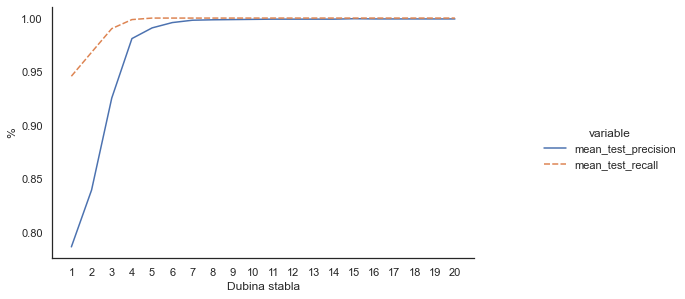

In [293]:
loaded = joblib.load("forest-250520211906.pkl")
results = pd.DataFrame(loaded.cv_results_)
removed = list(results.columns)
removed.remove("mean_test_precision")
removed.remove("mean_test_recall")
res = results.melt(id_vars=removed, value_vars=["mean_test_precision", "mean_test_recall"])



p1 = sns.relplot(
    data=res, kind="line",
    x="param_max_depth", y="value", hue="variable", style="variable", #col="param_criterion",
    #facet_kws=dict(sharey=True),
)
p1.fig.set_size_inches(10,4)
p1.set(xticks=list(range(1,21)))
p1.set(ylabel="%", xlabel="Dubina šume")

In [290]:
#results